In [7]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore


In [ ]:
%cd ~/Desktop

In [8]:
#load data
atlas_path = "/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives/templates/Schaefer2018_400Parcels_Tian_Subcortex_S4_2mm_2009c_NLinAsymm.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower") 

In [ ]:
# Load data
vols = pd.read_csv("irbio_folder/spreading_dynamics_clinical/derivatives/sub-10227/func/processed_sub-10227_mean_cope_resampled_ts_1vol.csv", sep='\t')
vols.index.name = 'Parcels'
vols.index += 1

vols = vols.reindex(sorted(vols.columns), axis=1)

In [12]:
"""zscored_vols = vols.apply(zscore, axis=1)

roi_iqr = zscored_vols.apply(lambda x: x.quantile(0.75) - x.quantile(0.25), axis=1)
print(roi_iqr)"""

'zscored_vols = vols.apply(zscore, axis=1)\n\nroi_iqr = zscored_vols.apply(lambda x: x.quantile(0.75) - x.quantile(0.25), axis=1)\nprint(roi_iqr)'

In [13]:
%cd irbio_folder/

/home/gabridele/Desktop/irbio_folder


Plotting for group: CTRL


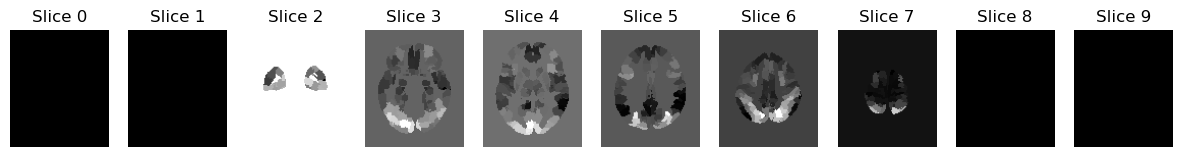

Plotting for group: SCZ


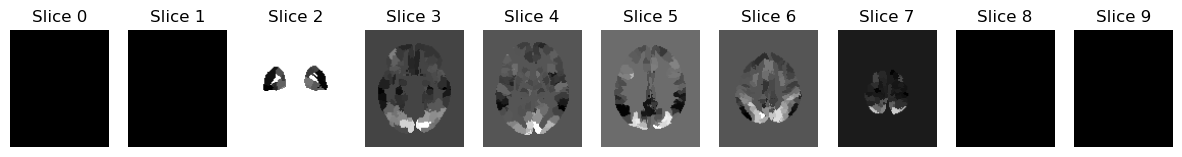

Plotting for group: BPLR


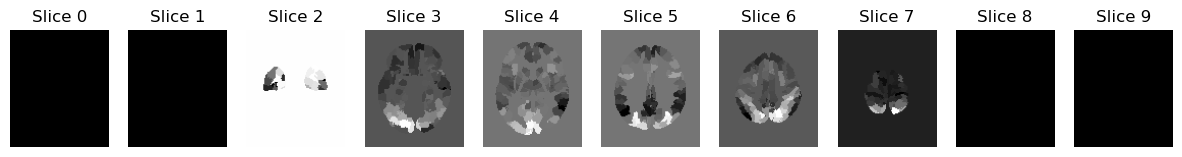

Plotting for group: ADHD


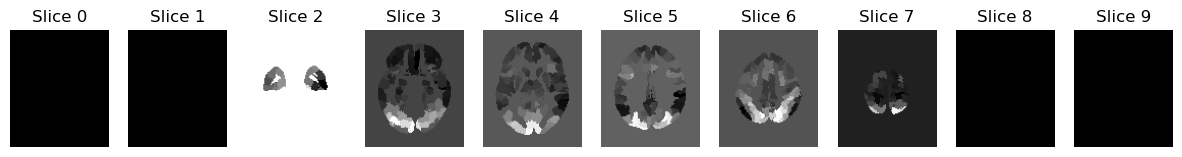

In [14]:
# get empirical mean activations on brain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import zscore
import nibabel as nib

# Define the base directory for your data files
base_dir = 'spreading_dynamics_clinical/preproc_dl/'

# Define groups and corresponding patterns
groups = {
    'CTRL': 'sub-1*/scap.feat/sub-1*_mean_cope_resampled_ts_1vol.npy',
    'SCZ': 'sub-5*/scap.feat/sub-5*_mean_cope_resampled_ts_1vol.npy',
    'BPLR': 'sub-6*/scap.feat/sub-6*_mean_cope_resampled_ts_1vol.npy',
    'ADHD': 'sub-7*/scap.feat/sub-7*_mean_cope_resampled_ts_1vol.npy'
}

target_shape = (454, 1)

"""def pad_matrix(matrix, target_shape):
    Pad matrix to the target shape with zeros
    current_shape = matrix.shape
    pad_height = target_shape[0] - current_shape[0]
    pad_width = target_shape[1] - current_shape[1]
    
    # Calculate padding widths
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    
    # Pad the matrix
    padded_matrix = np.pad(matrix, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
    return padded_matrix
"""

def load_data(files):
    data_list = []
    for file in files:
        data = np.load(file)
        data_list.append(data)
    return data_list

def compute_mean(subjects_data):
    if not subjects_data:
        return None
    
    correlation_matrices = np.array(subjects_data)
    mean_matrix = np.mean(correlation_matrices, axis=0)
    return mean_matrix

mean_matrices = {}

for group_name, pattern in groups.items():
    file_pattern = os.path.join(base_dir, pattern)
    files = glob.glob(file_pattern, recursive=True)
    if not files:
        print(f"No files found for pattern: {file_pattern}")
        continue
    subjects_data = load_data(files, target_shape)
    mean = compute_mean(subjects_data)
    if mean is None:
        print(f"No valid matrices for group: {group_name}")
        continue
    mean_matrices[group_name] = mean

# Load the atlas data
atlas_path = "spreading_dynamics_clinical/derivatives/templates/Schaefer2018_400Parcels_Tian_Subcortex_S4_2mm_2009c_NLinAsymm.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Function to map the mean activation values to the atlas
def map_activations_to_atlas(mean_activations, atlas_data):
    mapped_data = np.zeros_like(atlas_data)
    for roi_index in range(1, len(mean_activations) + 1):
        roi_indices = np.where(atlas_data == roi_index)
        mapped_data[roi_indices] = mean_activations[roi_index - 1]
    return mapped_data

# Function to display image slices
def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(15, 5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')
    plt.show()

# Function to plot slices of the mapped data
def plot_mapped_slices(mapped_data, num_slices=10):
    """ Function to plot slices of the mapped data """
    slices = [mapped_data[:, :, i] for i in np.linspace(0, mapped_data.shape[2] - 1, num_slices).astype(int)]
    show_slices(slices)

# Process and plot each group's mean data
for group_name, emp_mean_activations in mean_matrices.items():
    zscored = zscore(emp_mean_activations)
    np.save(f'{group_name}_emp_mean_activations.npy', zscored)
    mapped_data = map_activations_to_atlas(zscored, atlas_data)
    print(f'Plotting for group: {group_name}')
    plot_mapped_slices(mapped_data)

    # Save the mapped data to a NIfTI file
    mapped_img = nib.Nifti1Image(mapped_data, atlas_img.affine, header=atlas_img.header)
    nib.save(mapped_img, f'{group_name}_empirical_values_mapped.nii.gz')


In [ ]:
!pwd
%cd ../spreading_dynamics_clinical/derivatives/

In [16]:
import numpy as np
import glob
import os
import re
from scipy.stats import spearmanr, sem

# Define the base directory for your data files
base_dir = 'output_AFM_40'

# Define groups and corresponding patterns
patterns = {
    'CTRL': 'taskPredMatrix_sub-1*_40.npy',
    'SCZ': 'taskPredMatrix_sub-5*_40.npy',
    'BPLR': 'taskPredMatrix_sub-6*_40.npy',
    'ADHD': 'taskPredMatrix_sub-7*_40.npy'
}

def load_data(pattern, base_dir):
    # Load numpy arrays based on a file pattern.
    file_pattern = os.path.join(base_dir, pattern)
    files = glob.glob(file_pattern, recursive=True)
    data_list = [np.load(file) for file in files]
    return files, data_list

def find_other_file(sub_id, base_dir):
    # Find the corresponding other data file based on subject ID
    other_file_pattern = os.path.join(base_dir, '../../', f'preproc_dl/{sub_id}/scap.feat/mod_{sub_id}_mean_cope_resampled_ts_1vol.npy')
    print(other_file_pattern)
    files = glob.glob(other_file_pattern, recursive=True)
    return files[0] if files else None

def compute_spearman_correlation(data1, data2):
    # Compute Spearman correlation between two 1D arrays
    print(data1.shape)
    print(data2.shape)
    
    # Slice to 1D arrays
    data1_1d = data1[:, 0, 0]  # From (453, 1, 1) to (453,)
    data2_1d = data2[:, 0]  # From (453, 1) to (453,)
    print(data1_1d.shape)
    print(data2_1d.shape)
    if data1_1d.shape != data2_1d.shape:
        
        #print('data1_1d and data2_1d have diff shape')
        raise ValueError("Shapes of data1 and data2 do not match.")
    corr, _ = spearmanr(data1_1d, data2_1d)
    return corr

def compute_statistics(correlations):
    # Compute min, max, mean, SD, and SEM of correlation value
    if not correlations:
        return None, None, None, None, None
    
    correlations_array = np.array(correlations)
    min_corr = np.min(correlations_array)
    max_corr = np.max(correlations_array)
    mean_corr = np.mean(correlations_array)
    sd_corr = np.std(correlations_array, ddof=1)  # Use ddof=1 for sample SD
    sem_corr = sem(correlations_array)
    
    return min_corr, max_corr, mean_corr, sd_corr, sem_corr

def save_statistics(group_name, min_corr, max_corr, mean_corr, sd_corr, sem_corr):
    # Save computed statistics to a text fil
    with open(f'{group_name}_correlation_statistics.txt', 'w') as f:
        f.write(f"Statistics for group: {group_name}\n")
        f.write(f"Min Correlation: {min_corr}\n")
        f.write(f"Max Correlation: {max_corr}\n")
        f.write(f"Mean Correlation: {mean_corr}\n")
        f.write(f"SD Correlation: {sd_corr}\n")
        f.write(f"SEM Correlation: {sem_corr}\n")

# Process each group
for group_name, taskpred_pattern in patterns.items():
    print(f"Processing group: {group_name}")
    
    # Load the taskPredMatrix data
    taskpred_files, taskpred_data = load_data(taskpred_pattern, base_dir)
    
    correlations = []
    
    # Iterate over each taskPredMatrix file
    for taskpred_file, taskpred_array in zip(taskpred_files, taskpred_data):
        # Extract subject ID using regex
        sub_id_match = re.search(r'sub-(\d+)', taskpred_file)
        if sub_id_match:
            sub_id = sub_id_match.group(0)
            other_file = find_other_file(sub_id, base_dir)
            print(sub_id)
            if other_file:
                other_data = np.load(other_file)
                correlation = compute_spearman_correlation(taskpred_array, other_data)
                print(correlation)
                correlations.append(correlation)
            else:
                print(f"No corresponding file found for subject: {sub_id}")
    
    # Compute and save statistics
    min_corr, max_corr, mean_corr, sd_corr, sem_corr = compute_statistics(correlations)
    save_statistics(group_name, min_corr, max_corr, mean_corr, sd_corr, sem_corr)
    print(f"{group_name} - Min: {min_corr}, Max: {max_corr}, Mean: {mean_corr}, SD: {sd_corr}, SEM: {sem_corr}")


Processing group: CTRL
CTRL - Min: None, Max: None, Mean: None, SD: None, SEM: None
Processing group: SCZ
SCZ - Min: None, Max: None, Mean: None, SD: None, SEM: None
Processing group: BPLR
BPLR - Min: None, Max: None, Mean: None, SD: None, SEM: None
Processing group: ADHD
ADHD - Min: None, Max: None, Mean: None, SD: None, SEM: None


In [9]:
!pwd
%cd ../spreading_dynamics_clinical/derivatives/

/home/gabridele/Desktop/irbio_folder/code
/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives


In [14]:
import numpy as np
import pandas as pd
import glob
import os
import re
from scipy.stats import spearmanr, sem

# Define the base directory for your data files
base_dir = os.getcwd()

# Define groups and corresponding patterns
groups = {
    'CTRL': 'sub-1*/dwi/processed_association_matrix_sub-1*_40seeds.csv',
    'SCZ': 'sub-5*/dwi/processed_association_matrix_sub-5*_40seeds.csv',
    'BPLR': 'sub-6*/dwi/processed_association_matrix_sub-6*_40seeds.csv',
    'ADHD': 'sub-7*/dwi/processed_association_matrix_sub-7*_40seeds.csv'
}

def load_data(pattern, base_dir):
    """Load numpy arrays based on a file pattern."""
    file_pattern = os.path.join(base_dir, pattern)
    files = glob.glob(file_pattern, recursive=True)
    data_list = [pd.read_csv(file, header=None).to_numpy() for file in files]
    return files, data_list

def find_other_file(sub_id, base_dir):
    """Find the corresponding other data file based on subject ID."""
    other_file_pattern = os.path.join(base_dir, f'{sub_id}/func/mod_{sub_id}_rs_correlation_matrix.npy')  # Removed leading '/'
    files = glob.glob(other_file_pattern, recursive=True)
    return files[0] if files else None

def compute_spearman_correlation(data1, data2):
    """Compute Spearman correlation between two 1D arrays."""
    # Make sure the data is sliced correctly for your use case

    data1_1d = data1.flatten()
    data2_1d = data2.flatten()

    if data1_1d.shape != data2_1d.shape:
        raise ValueError("Shapes of data1 and data2 do not match.")
    corr, pval = spearmanr(data1_1d, data2_1d)
    return corr, pval

def compute_statistics(correlations):
    """Compute min, max, mean, SD, and SEM of correlation values."""
    if not correlations:
        return None, None, None, None, None
    
    correlations_array = np.array(correlations)
    min_corr = np.min(correlations_array)
    max_corr = np.max(correlations_array)
    mean_corr = np.mean(correlations_array)
    sd_corr = np.std(correlations_array, ddof=1)  # Use ddof=1 for sample SD
    sem_corr = sem(correlations_array)
    
    return min_corr, max_corr, mean_corr, sd_corr, sem_corr

def save_statistics(group_name, min_corr, max_corr, mean_corr, sd_corr, sem_corr, p_min, p_max):
    """Save computed statistics to a text file."""
    with open(f'{group_name}_correlation_statistics.txt', 'w') as f:
        f.write(f"Statistics for group: {group_name}\n")
        f.write(f"Min Correlation: {min_corr}\n")
        f.write(f"Max Correlation: {max_corr}\n")
        f.write(f"Mean Correlation: {mean_corr}\n")
        f.write(f"p-value min: {p_min}\n")
        f.write(f"p-value max: {p_max}\n")
        f.write(f"SD Correlation: {sd_corr}\n")
        f.write(f"SEM Correlation: {sem_corr}\n")

# Process each group
for group_name, taskpred_pattern in groups.items():  # Fixed typo
    print(f"Processing group: {group_name}")
    
    # Load the taskPredMatrix data
    taskpred_files, taskpred_data = load_data(taskpred_pattern, base_dir)
    
    correlations = []
    pvals = []

    # Iterate over each taskPredMatrix file
    for taskpred_file, taskpred_array in zip(taskpred_files, taskpred_data):
        # Extract subject ID using regex
        sub_id_match = re.search(r'sub-(\d+)', taskpred_file)
        if sub_id_match:
            sub_id = sub_id_match.group(0)
            other_file = find_other_file(sub_id, base_dir)
            if other_file:
                other_data = np.load(other_file)
                correlation, pval = compute_spearman_correlation(taskpred_array, other_data)
                print(pval)
                pvals.append(pval)
                correlations.append(correlation)
            else:
                print(f"No corresponding file found for subject: {sub_id}")
    print(pvals)
    # Compute and save statistics
    min_corr, max_corr, mean_corr, sd_corr, sem_corr = compute_statistics(correlations)

    p_max = np.max(pvals)
    p_min = np.min(pvals)
    if min_corr is not None:
        save_statistics(group_name, min_corr, max_corr, mean_corr, sd_corr, sem_corr, p_min, p_max)
        print(f"{group_name} - Min: {min_corr}, Max: {max_corr}, Mean: {mean_corr}, SD: {sd_corr}, SEM: {sem_corr}")
    else:
        print(f"No correlations were computed for group: {group_name}")


Processing group: CTRL
0.0
0.0
No corresponding file found for subject: sub-10171
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2.349071357981438e-268
0.0
0.0
0.0
0.0
0.0
3.2217244677490564e-295
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.6499310344631596e-226
0.0
0.0
0.0
0.0
0.0
No corresponding file found for subject: sub-11067
0.0
0.0
0.0
0.0
No corresponding file found for subject: sub-10225
1.1280938665815124e-212
0.0
1.7607474365600514e-196
3.6059110401554648e-264
0.0
0.0
0.0
0.0
0.0
1.979285326084076e-36
0.0
0.0
0.0
No corresponding file found for subject: sub-10304
9.611963565521359e-202
0.0
0.0
0.0
0.0
3.9435871677980845e-95
0.0
No corresponding file found for subject: sub-10524
0.0
0.0
0.0
0.0
No corresponding file found for subject: sub-10429
No corresponding file found for subject: sub-11062
No corresponding file found for subject: sub-10280
0.0
0.0
0.0
0.0
0.0
0.0
0.0
No corresponding file found for subject: sub-10882
No corresponding file found for subject: sub-10376
0.0
2.9512825598573565e-265


In [ ]:
min_ctrl = [0.041, 0.024, 0.008, 0.012, 0.027]
max_ctrl = [0.215, 0.219, 0.21, 0.203, 0.211]
sd_ctrl = [0.035, 0.036, 0.036, 0.035, 0.033]
sem_ctrl = [0.003, 0.004, 0.004, 0.004, 0.004]

min_scz = [0.046, 0.054, 0.051, 0.048, 0.043]
max_scz = [0.139, 0.145, 0.142, 0.143, 0.147]
sd_scz = [0.022, 0.023, 0.025, 0.024, 0.025]
sem_scz = [0.005, 0.005, 0.006, 0.006, 0.006]

min_bplr = [0.021, 0.046, 0.045, 0.05, 0.053]
max_bplr = [0.16, 0.148, 0.145, 0.151, 0.157]
sd_bplr = [0.031, 0.027, 0.028, 0.028, 0.028]
sem_bplr = [0.005, 0.005, 0.005, 0.005, 0.005]

min_adhd = [0.055, 0.048, 0.044, 0.051, 0.051]
max_adhd = [0.17, 0.165, 0.158, 0.159, 0.162]
sd_adhd = [0.03, 0.028, 0.028, 0.026, 0.026]
sem_adhd = [0.005, 0.005, 0.005, 0.005, 0.005]

In [53]:
!pwd

/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical/derivatives


Plotting for group: CTRL


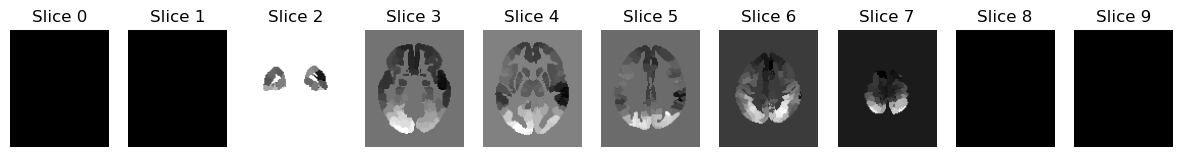

Plotting for group: SCZ


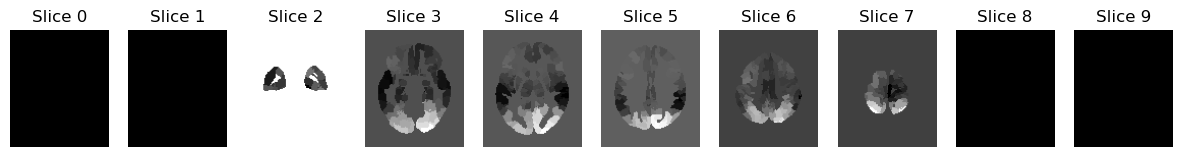

Plotting for group: BPLR


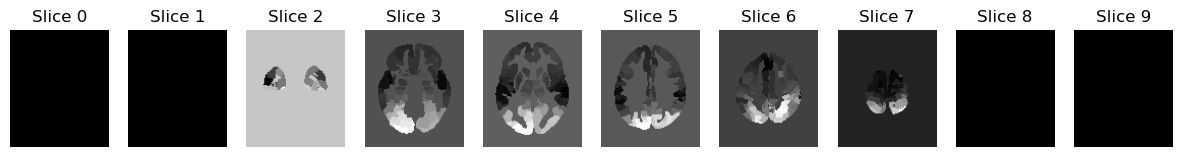

Plotting for group: ADHD


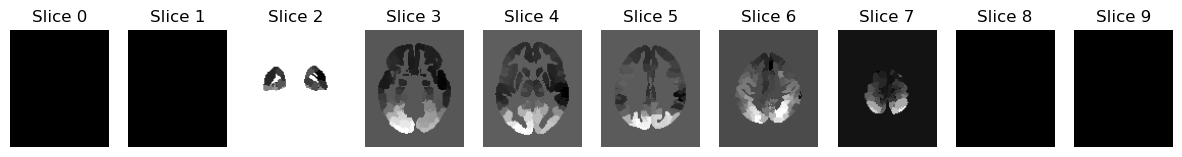

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import nibabel as nib

# Define the base directory for your data files
base_dir = 'spreading_dynamics_clinical/derivatives/output_AFM_40'

# Define groups and corresponding patterns
groups = {
    'CTRL': 'taskPredMatrix_sub-1*_40.npy',
    'SCZ': 'taskPredMatrix_sub-5*_40.npy',
    'BPLR': 'taskPredMatrix_sub-6*_40.npy',
    'ADHD': 'taskPredMatrix_sub-7*_40.npy'
}
target_shape = (454, 1, 1)

def load_data(files):
    data_list = []
    for file in files:
        data = np.load(file)
        if data.ndim == 1:
            data = data[:, np.newaxis, np.newaxis]  # Convert to (n, 1, 1) shape
        data_list.append(data)
    return data_list

def compute_statistics(subjects_data):
    if not subjects_data:
        return None, None, None
    
    correlation_matrices = np.array(subjects_data)
    min_matrix = np.min(correlation_matrices, axis=0)
    max_matrix = np.max(correlation_matrices, axis=0)
    sem_matrix = sem(correlation_matrices, axis=0)
    
    return min_matrix, max_matrix, sem_matrix

mean_matrices = {}
for group_name, pattern in groups.items():
    file_pattern = os.path.join(base_dir, pattern)
    files = glob.glob(file_pattern, recursive=True)
    if not files:
        print(f"No files found for pattern: {file_pattern}")
        continue
    subjects_data = load_data(files, target_shape)
    mean = compute_mean(subjects_data)
    if mean is None:
        print(f"No valid matrices for group: {group_name}")
        continue
    mean_matrices[group_name] = mean

# Load the atlas data
atlas_path = "spreading_dynamics_clinical/derivatives/templates/Schaefer2018_400Parcels_Tian_Subcortex_S4_2mm_2009c_NLinAsymm.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Function to map the mean activation values to the atlas
def map_activations_to_atlas(mean_activations, atlas_data):
    mapped_data = np.zeros_like(atlas_data)
    for roi_index in range(1, len(mean_activations) + 1):
        roi_indices = np.where(atlas_data == roi_index)
        mapped_data[roi_indices] = mean_activations[roi_index - 1]
    return mapped_data

# Function to display image slices
def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(15, 5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')
    plt.show()

# Function to plot slices of the mapped data
def plot_mapped_slices(mapped_data, num_slices=10):
    """ Function to plot slices of the mapped data """
    slices = [mapped_data[:, :, i] for i in np.linspace(0, mapped_data.shape[2] - 1, num_slices).astype(int)]
    show_slices(slices)

# Process and plot each group's mean data
for group_name, pred_mean_activations in mean_matrices.items():
    zscored = zscore(pred_mean_activations)
    np.save(f'{group_name}_pred_mean_activations.npy', zscored)
    mapped_data = map_activations_to_atlas(zscored, atlas_data)
    print(f'Plotting for group: {group_name}')
    plot_mapped_slices(mapped_data)

    # Save the mapped data to a NIfTI file
    mapped_img = nib.Nifti1Image(mapped_data, atlas_img.affine, header=atlas_img.header)
    nib.save(mapped_img, f'{group_name}_predicted_values_mapped.nii.gz')


In [8]:
!pwd
%cd ../

/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical
/home/gabridele/Desktop/irbio_folder


In [30]:
from scipy.stats import spearmanr
import numpy as np
BPLR_pred = np.load('ADHD_pred_mean_activations.npy')
BPLR_emp = np.load('ADHD_emp_mean_activations.npy')

vector_pred = BPLR_pred.flatten()
vector_emp = BPLR_emp.flatten()

correlation, p_value = spearmanr(vector_pred, vector_emp)
print(correlation, p_value)

0.6660543529172638 1.5918738937458481e-59


In [31]:
import matplotlib.pyplot as plt

def scatter_plot_func(p_array, e_array, spearman_corr, spearman_p_val, sub_id=None, save_dir=None, n_seeds=None):
    
    # make sure value is of float type
    spearman_corr = float(spearman_corr)
    spearman_p_val = float(spearman_p_val)
    
    pred_values = p_array
    actual_values = e_array

    plt.figure()
    plt.scatter(range(len(pred_values)), pred_values, color='lightblue', label='Predicted Activation')
    plt.scatter(range(len(actual_values)), actual_values, color='lightcoral', label='Empirical Activation')

    plt.title(
        f'Predicted vs Empirical Activation for {sub_id} - {n_seeds}-seeds association matrix based' if sub_id 
        else f'Predicted vs Empirical Activation - {n_seeds}-seeds association matrix based',
        fontsize=13  # Title font size
    )
    plt.xlabel('Region', fontsize=14)  # X-axis label font size
    plt.ylabel('Activation', fontsize=14)  # Y-axis label font size

    # Set the tick parameters
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend(
        loc='upper left',  # position inside the plot
        bbox_to_anchor=(1.05, 1),  # move legend outside the plot
        borderaxespad=0.,
        fontsize=13,  # Legend font size
        title_fontsize=13,  # Legend title font size
        title=f"Spearman's $\\rho$: {spearman_corr:.3f} (p={spearman_p_val:.2g})"
    )

    if save_dir and sub_id:
        save_path = f"{save_dir}/scatter_plot_{sub_id}.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()
    
    return


In [3]:
%cd ../

/home/gabridele/Desktop/irbio_folder


Plotting for group: CTRL


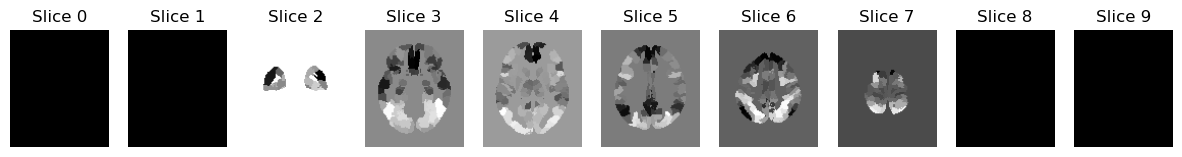

Plotting for group: SCZ


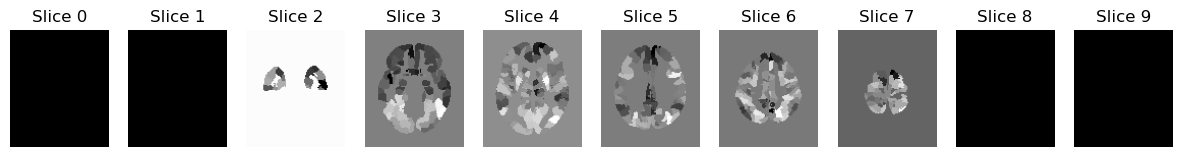

Plotting for group: BPLR


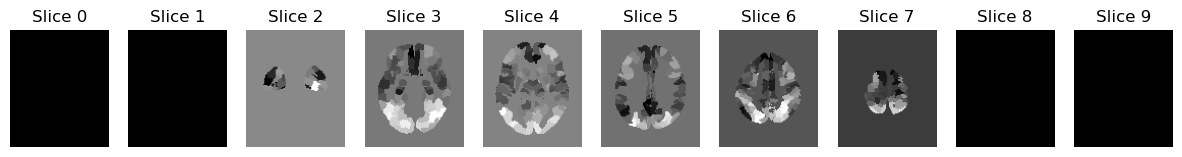

Plotting for group: ADHD


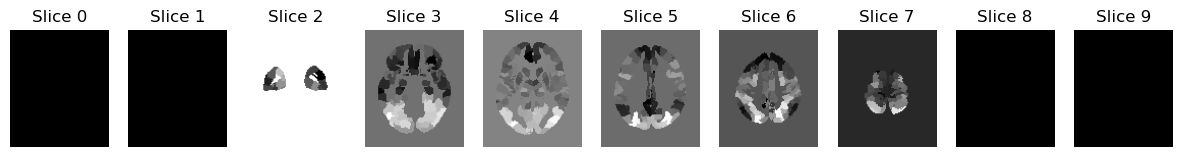

In [5]:
# predicted with fc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import nibabel as nib
from scipy.stats import zscore

# Define the base directory for your data files
base_dir = 'spreading_dynamics_clinical/derivatives/output_AFM_rs'

# Define groups and corresponding patterns
groups = {
    'CTRL': 'taskPredMatrix_sub-1*_rs.npy',
    'SCZ': 'taskPredMatrix_sub-5*_rs.npy',
    'BPLR': 'taskPredMatrix_sub-6*_rs.npy',
    'ADHD': 'taskPredMatrix_sub-7*_rs.npy'
}
target_shape = (454, 1, 1)

def load_data(files, target_shape):
    data_list = []
    for file in files:
        data = np.load(file)
        if data.ndim == 1:
            data = data[:, np.newaxis, np.newaxis]  # Convert to (n, 1, 1) shape
        data_list.append(data)
    return data_list

def compute_mean(subjects_data):
    if not subjects_data:
        return None
    
    correlation_matrices = np.array(subjects_data)
    mean_matrix = np.mean(correlation_matrices, axis=0)
    return mean_matrix

mean_matrices = {}
for group_name, pattern in groups.items():
    file_pattern = os.path.join(base_dir, pattern)
    files = glob.glob(file_pattern, recursive=True)
    if not files:
        print(f"No files found for pattern: {file_pattern}")
        continue
    subjects_data = load_data(files, target_shape)
    mean = compute_mean(subjects_data)
    if mean is None:
        print(f"No valid matrices for group: {group_name}")
        continue
    mean_matrices[group_name] = mean

# Load the atlas data
atlas_path = "spreading_dynamics_clinical/derivatives/templates/Schaefer2018_400Parcels_Tian_Subcortex_S4_2mm_2009c_NLinAsymm.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Function to map the mean activation values to the atlas
def map_activations_to_atlas(mean_activations, atlas_data):
    mapped_data = np.zeros_like(atlas_data)
    for roi_index in range(1, len(mean_activations) + 1):
        roi_indices = np.where(atlas_data == roi_index)
        mapped_data[roi_indices] = mean_activations[roi_index - 1]
    return mapped_data

# Function to display image slices
def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(15, 5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')
    plt.show()

# Function to plot slices of the mapped data
def plot_mapped_slices(mapped_data, num_slices=10):
    """ Function to plot slices of the mapped data """
    slices = [mapped_data[:, :, i] for i in np.linspace(0, mapped_data.shape[2] - 1, num_slices).astype(int)]
    show_slices(slices)

# Process and plot each group's mean data
for group_name, pred_mean_activations in mean_matrices.items():
    zscored = zscore(pred_mean_activations)
    np.save(f'{group_name}_pred_fc_mean_activations.npy', zscored)
    mapped_data = map_activations_to_atlas(zscored, atlas_data)
    print(f'Plotting for group: {group_name}')
    plot_mapped_slices(mapped_data)

    # Save the mapped data to a NIfTI file
    mapped_img = nib.Nifti1Image(mapped_data, atlas_img.affine, header=atlas_img.header)
    nib.save(mapped_img, f'{group_name}_predicted_fc_values_mapped.nii.gz')

Plotting for group: CTRL


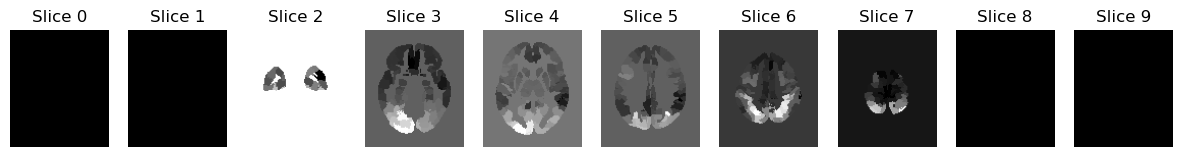

Plotting for group: SCZ


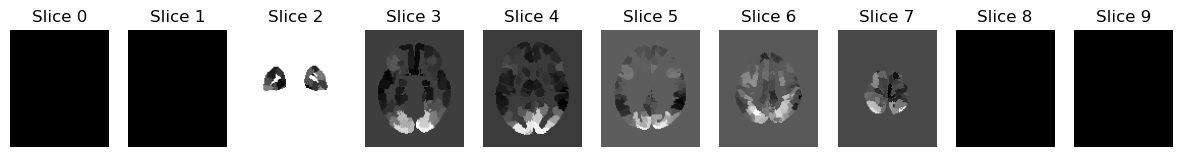

Plotting for group: BPLR


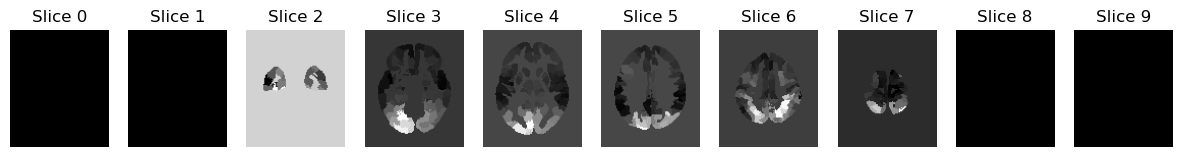

Plotting for group: ADHD


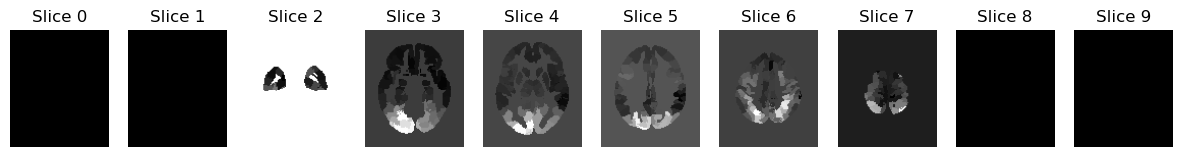

In [6]:
# predicted with SC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import nibabel as nib
from scipy.stats import zscore

# Define the base directory for your data files
base_dir = 'spreading_dynamics_clinical/derivatives/output_AFM_SC'

# Define groups and corresponding patterns
groups = {
    'CTRL': 'taskPredMatrix_sub-1*_SC.npy',
    'SCZ': 'taskPredMatrix_sub-5*_SC.npy',
    'BPLR': 'taskPredMatrix_sub-6*_SC.npy',
    'ADHD': 'taskPredMatrix_sub-7*_SC.npy'
}
target_shape = (454, 1, 1)


def load_data(files):
    data_list = []
    for file in files:
        data = np.load(file)
        if data.ndim == 1:
            data = data[:, np.newaxis, np.newaxis]  # Convert to (n, 1, 1) shape
        data_list.append(data)
    return data_list

def compute_mean(subjects_data):
    if not subjects_data:
        return None
    
    correlation_matrices = np.array(subjects_data)
    mean_matrix = np.mean(correlation_matrices, axis=0)
    return mean_matrix

mean_matrices = {}
for group_name, pattern in groups.items():
    file_pattern = os.path.join(base_dir, pattern)
    files = glob.glob(file_pattern, recursive=True)
    if not files:
        print(f"No files found for pattern: {file_pattern}")
        continue
    subjects_data = load_data(files, target_shape)
    mean = compute_mean(subjects_data)
    if mean is None:
        print(f"No valid matrices for group: {group_name}")
        continue
    mean_matrices[group_name] = mean

# Load the atlas data
atlas_path = "spreading_dynamics_clinical/derivatives/templates/Schaefer2018_400Parcels_Tian_Subcortex_S4_2mm_2009c_NLinAsymm.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Function to map the mean activation values to the atlas
def map_activations_to_atlas(mean_activations, atlas_data):
    mapped_data = np.zeros_like(atlas_data)
    for roi_index in range(1, len(mean_activations) + 1):
        roi_indices = np.where(atlas_data == roi_index)
        mapped_data[roi_indices] = mean_activations[roi_index - 1]
    return mapped_data

# Function to display image slices
def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(15, 5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')
    plt.show()

# Function to plot slices of the mapped data
def plot_mapped_slices(mapped_data, num_slices=10):
    """ Function to plot slices of the mapped data """
    slices = [mapped_data[:, :, i] for i in np.linspace(0, mapped_data.shape[2] - 1, num_slices).astype(int)]
    show_slices(slices)

# Process and plot each group's mean data
for group_name, pred_mean_activations in mean_matrices.items():
    zscored = zscore(pred_mean_activations)
    np.save(f'{group_name}_pred_sc_mean_activations.npy', zscored)
    mapped_data = map_activations_to_atlas(zscored, atlas_data)
    print(f'Plotting for group: {group_name}')
    plot_mapped_slices(mapped_data)

    # Save the mapped data to a NIfTI file
    mapped_img = nib.Nifti1Image(mapped_data, atlas_img.affine, header=atlas_img.header)
    nib.save(mapped_img, f'{group_name}_predicted_sc_values_mapped.nii.gz')

In [39]:
%cd ..

/home/gabridele/Desktop/irbio_folder


In [60]:
from scipy.stats import spearmanr
CTRL_sc = np.load('fc_values/ADHD_pred_fc_mean_activations.npy')
CTRL_emp = np.load('ADHD_emp_mean_activations.npy')

vector_pred = CTRL_sc.flatten()
vector_emp = CTRL_emp.flatten()

correlation, p_value = spearmanr(vector_pred, vector_emp)
print(correlation, p_value)

0.7317892656691267 2.7823366412627215e-77


In [54]:
def scatter_plot_func(p_array, e_array, spearman_corr, spearman_p_val, sub_id=None, save_dir=None, n_seeds=None):
    
    # make sure value is of float type
    spearman_corr = float(spearman_corr)
    spearman_p_val = float(spearman_p_val)
    
    pred_values = p_array
    actual_values = e_array

    plt.figure()
    plt.scatter(range(len(pred_values)), pred_values, color='lightblue', label='Predicted Activation')
    plt.scatter(range(len(actual_values)), actual_values, color='lightcoral', label='Empirical Activation')

    plt.title(f'Predicted vs Empirical Activation for {sub_id} - Functional Connectivity based' if sub_id else f'Predicted vs Empirical Activation - {n_seeds}-seeds association matrix based')

    plt.xlabel('Region', fontsize=14)  # X-axis label font size
    plt.ylabel('Activation', fontsize=14)  # Y-axis label font size

    # Set the tick parameters
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend(
        loc='upper left',  # position inside the plot
        bbox_to_anchor=(1.05, 1),  # move legend outside the plot
        borderaxespad=0.,
        fontsize=13,  # Legend font size
        title_fontsize=13,  # Legend title font size
        title=f"Spearman's $\\rho$: {spearman_corr:.3f} (p={spearman_p_val:.2g})"
    )

    if save_dir and sub_id:
        save_path = f"{save_dir}/scatter_plot_{sub_id}.png"
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()
    
    return

Plot saved to ./scatter_plot_ADHD.png


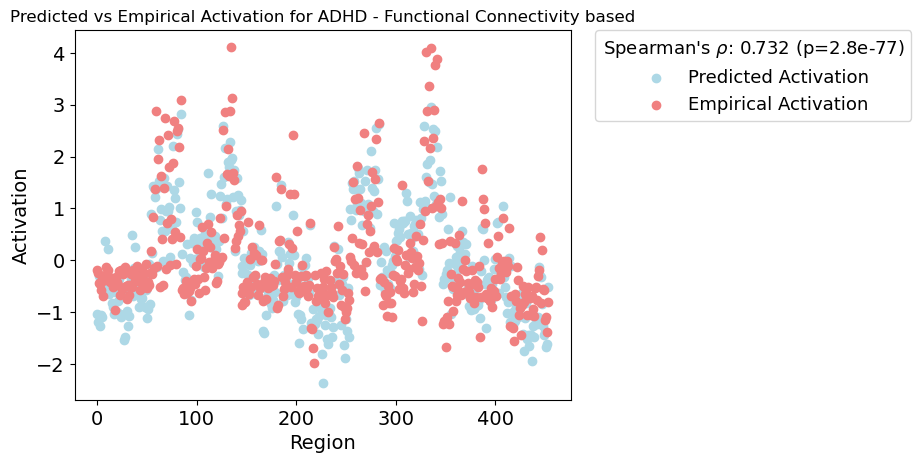

In [61]:
save_dir='.'
sub_id='ADHD'
#n_seeds=

scatter_plot_func(CTRL_sc, CTRL_emp, correlation, p_value, sub_id, save_dir)

In [2]:
!pwd

/home/gabridele/Desktop/irbio_folder/code


In [3]:
%cd ..

/home/gabridele/Desktop/irbio_folder


In [11]:
import pandas as pd

# Load the labels file
labels_filename = '../../Downloads/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S4_label.txt'  # Replace with your actual path
network_names = ["Vis", "SomMot", "DorsAttn", "SalVentAttn", "Limbic", "Cont", "Default"]
region_to_network = {}

with open(labels_filename, 'r') as file:
    lines = file.readlines()[108:]  # Start reading from line 109 (index 108)
    
    for i in range(0, len(lines), 2):  # Process lines in pairs
        if i + 1 < len(lines):
            name_line = lines[i].strip()
            index_line = lines[i + 1].strip()
            
            name_parts = name_line.split('_')
            index_parts = index_line.split()
            
            if len(name_parts) >= 4 and len(index_parts) > 0:
                network_name = name_parts[2]  # Extract the network name
                try:
                    region_index = int(index_parts[0])  # Extract the region index
                    if network_name in network_names:
                        region_to_network[region_index] = network_name
                except ValueError:
                    continue  # Skip lines where the region index is not an integer


print(region_to_network)  # Print to verify the mapping

{55: 'Vis', 56: 'Vis', 57: 'Vis', 58: 'Vis', 59: 'Vis', 60: 'Vis', 61: 'Vis', 62: 'Vis', 63: 'Vis', 64: 'Vis', 65: 'Vis', 66: 'Vis', 67: 'Vis', 68: 'Vis', 69: 'Vis', 70: 'Vis', 71: 'Vis', 72: 'Vis', 73: 'Vis', 74: 'Vis', 75: 'Vis', 76: 'Vis', 77: 'Vis', 78: 'Vis', 79: 'Vis', 80: 'Vis', 81: 'Vis', 82: 'Vis', 83: 'Vis', 84: 'Vis', 85: 'Vis', 86: 'SomMot', 87: 'SomMot', 88: 'SomMot', 89: 'SomMot', 90: 'SomMot', 91: 'SomMot', 92: 'SomMot', 93: 'SomMot', 94: 'SomMot', 95: 'SomMot', 96: 'SomMot', 97: 'SomMot', 98: 'SomMot', 99: 'SomMot', 100: 'SomMot', 101: 'SomMot', 102: 'SomMot', 103: 'SomMot', 104: 'SomMot', 105: 'SomMot', 106: 'SomMot', 107: 'SomMot', 108: 'SomMot', 109: 'SomMot', 110: 'SomMot', 111: 'SomMot', 112: 'SomMot', 113: 'SomMot', 114: 'SomMot', 115: 'SomMot', 116: 'SomMot', 117: 'SomMot', 118: 'SomMot', 119: 'SomMot', 120: 'SomMot', 121: 'SomMot', 122: 'SomMot', 123: 'DorsAttn', 124: 'DorsAttn', 125: 'DorsAttn', 126: 'DorsAttn', 127: 'DorsAttn', 128: 'DorsAttn', 129: 'DorsAttn'

In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import nibabel as nib
#from scipy.stats import zscore

atlas_path = "spreading_dynamics_clinical/derivatives/templates/Schaefer2018_400Parcels_Tian_Subcortex_S4_2mm_2009c_NLinAsymm.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Print the shape of the atlas data to check
print(atlas_data.shape)

(97, 115, 97)


In [2]:
!pwd
%cd ..

/home/gabridele/Desktop/irbio_folder/code
/home/gabridele/Desktop/irbio_folder


In [ ]:

# Load the original atlas

original_atlas_img = nib.load(atlas_path)
original_atlas_data = original_atlas_img.get_fdata()

network_names = ["Vis", "SomMot", "DorsAttn", "SalVentAttn", "Limbic", "Cont", "Default"]
network_to_id = {name: idx + 1 for idx, name in enumerate(network_names)}

# Initialize the grouped atlas with zeros
grouped_atlas_data = np.zeros_like(original_atlas_data)

# Map regions to numeric IDs
for region_id, network_name in region_to_network.items():
    network_id = network_to_id.get(network_name, 0)  # Default to 0 if network_name not found
    # Find the indices where the region_id is present
    region_indices = np.where(original_atlas_data == region_id)
    # Assign the network ID to these indices in the grouped atlas
    grouped_atlas_data[region_indices] = network_id

# Create a new NIfTI image for the grouped atlas
grouped_atlas_img = nib.Nifti1Image(grouped_atlas_data, original_atlas_img.affine)

# Save the grouped atlas
grouped_atlas_filename = 'grouped_atlas.nii.gz'
nib.save(grouped_atlas_img, grouped_atlas_filename)

print(f"Grouped atlas saved to {grouped_atlas_filename}")

In [ ]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths for atlas and activation files
grouped_atlas_filename = 'grouped_atlas.nii.gz'
colors = ["#66c2a4", "#ffd700", "#b3b3ff", "#ff8080"]
group_names = ["CTRL", "SCZ", "BPLR", "ADHD"]
group_files = [
    'spreading_dynamics_clinical/figures/CTRL_empirical_values_mapped.nii.gz',  
    'spreading_dynamics_clinical/figures/SCZ_empirical_values_mapped.nii.gz',   
    'spreading_dynamics_clinical/figures/BPLR_empirical_values_mapped.nii.gz',
    'spreading_dynamics_clinical/figures/ADHD_empirical_values_mapped.nii.gz'
]

# Load the grouped atlas
grouped_atlas_img = nib.load(grouped_atlas_filename)
grouped_atlas_data = grouped_atlas_img.get_fdata()

def map_activations_to_atlas(activation_filename, grouped_atlas_data, group_name):
    activation_img = nib.load(activation_filename)
    activation_data = activation_img.get_fdata()

    network_activations = {}

    # Extract unique network IDs from the grouped atlas
    unique_networks = np.unique(grouped_atlas_data)
    unique_networks = unique_networks[unique_networks > 0]  # Exclude background

    # Extract activation values for each network
    for network_id in unique_networks:
        network_mask = grouped_atlas_data == network_id
        network_activation_values = activation_data[network_mask]
        network_activations[f'Network_{int(network_id)}'] = network_activation_values

    # Convert to DataFrame
    activation_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in network_activations.items()]))
    activation_df = activation_df.melt(var_name='Network', value_name='Activation')
    activation_df['Group'] = group_name
    activation_df.dropna(inplace=True)
    
    return activation_df

# Process each activation file and combine the data
all_activations = []

for group_name, activation_file in zip(group_names, group_files):
    group_activation_df = map_activations_to_atlas(activation_file, grouped_atlas_data, group_name)
    all_activations.append(group_activation_df)

combined_activation_df = pd.concat(all_activations, ignore_index=True)

network_color = {
    "Vis": "black",
    "SomMot": "blue",
    "DorsAttn": "darkgreen",
    "SalVentAttn": "lightgreen",
    "Limbic": "yellow",
    "Cont": "orange",
    "Default": "red"
}

# Create the boxplot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Network', y='Activation', hue='Group', data=combined_activation_df, palette=colors)

# Add a horizontal line at y=0
ax.axhline(y=0, color='grey', linestyle='--', zorder=1)

# Remove x-axis labels
ax.set_xticklabels([])

# Remove upper and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize the plot
plt.title('')
plt.xlabel('')
plt.ylabel('Activity (beta)')
plt.xticks(rotation=45)

# Customize legend
plt.legend(title='Group', fontsize=12, title_fontsize='13')  # Increase legend size

plt.tight_layout()

# Save and show the plot
plt.savefig('activation_by_network_group_boxplot.png', dpi=300)
plt.show()

In [14]:
from scipy import stats
import numpy as np

# Initialize lists to hold results
t_test_results = []
effect_sizes = []

# Define the groups to compare with 'CTRL'
comparison_groups = ['SCZ', 'BPLR', 'ADHD']

# Perform t-tests for each network and each pair with 'CTRL'
for network in combined_activation_df['Network'].unique():
    network_data = combined_activation_df[combined_activation_df['Network'] == network]
    
    for group in comparison_groups:
        # Subset the data for the two groups: 'CTRL' and the current group
        ctrl_data = network_data[network_data['Group'] == 'CTRL']['Activation']
        group_data = network_data[network_data['Group'] == group]['Activation']
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(ctrl_data, group_data)
        
        # Calculate Cohen's d for effect size
        mean_diff = np.mean(ctrl_data) - np.mean(group_data)
        pooled_std = np.sqrt(((len(ctrl_data) - 1) * np.var(ctrl_data) + (len(group_data) - 1) * np.var(group_data)) / (len(ctrl_data) + len(group_data) - 2))
        cohen_d = mean_diff / pooled_std
        
        t_test_results.append({
            'Network': network,
            'Comparison': f'CTRL vs {group}',
            't-statistic': t_stat,
            'p-value': p_val
        })
        
        effect_sizes.append({
            'Network': network,
            'Comparison': f'CTRL vs {group}',
            'Cohen\'s d': cohen_d
        })

# Convert results to DataFrame
t_test_df = pd.DataFrame(t_test_results)
effect_size_df = pd.DataFrame(effect_sizes)

# Adjust p-values for multiple comparisons using Benjamini-Hochberg
t_test_df['p-adjusted'] = multipletests(t_test_df['p-value'], method='fdr_bh')[1]

# Display t-test and effect size results
print("T-Test Results:")
print(t_test_df)

print("\nEffect Sizes:")
print(effect_size_df)


T-Test Results:
      Network    Comparison  t-statistic        p-value     p-adjusted
0   Network_1   CTRL vs SCZ   -44.873327   0.000000e+00   0.000000e+00
1   Network_1  CTRL vs BPLR   -29.003979  2.245765e-183  6.737296e-183
2   Network_1  CTRL vs ADHD   -53.153986   0.000000e+00   0.000000e+00
3   Network_2   CTRL vs SCZ   -21.961477  2.969422e-106  5.196489e-106
4   Network_2  CTRL vs BPLR   -23.204203  2.620646e-118  5.003051e-118
5   Network_2  CTRL vs ADHD    -3.915639   9.031829e-05   9.483420e-05
6   Network_3   CTRL vs SCZ    24.881309  2.905297e-135  6.101123e-135
7   Network_3  CTRL vs BPLR     8.830152   1.101683e-18   1.217649e-18
8   Network_3  CTRL vs ADHD    11.166493   6.793591e-29   8.392084e-29
9   Network_4   CTRL vs SCZ   -12.203602   3.601399e-34   4.726837e-34
10  Network_4  CTRL vs BPLR   -10.498034   9.800671e-26   1.143412e-25
11  Network_4  CTRL vs ADHD   -13.074804   5.900944e-39   8.261321e-39
12  Network_5   CTRL vs SCZ   115.048340   0.000000e+00   0.0

In [34]:
!pwd


/home/gabridele/Desktop/irbio_folder


In [3]:
%cd ../spreading_dynamics_clinical/

/home/gabridele/Desktop/irbio_folder/spreading_dynamics_clinical


In [5]:
file_path = 'streams_count_per_roi_per_subj.csv'  # Replace with the path to your CSV file
df = pd.read_csv(file_path, sep=',', header=0)

In [6]:
df

,Unnamed: 0,0
0,0,25241
1,1,26857
2,2,12077
3,3,43454
4,4,27662
...,...,...
601,601,24104
602,602,40757
603,603,38923
604,604,35020
